# PyTorch Neural Network Digits Classifier
**Dataset:** MNIST

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch import nn
from torch import optim
import torch.nn.functional as F

**Download _MNIST_ dataset**  
I will be using batches of 64

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])
                             
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [0]:
def print_sample_digit(index):
    print(str.format('Label: {}',labels[index]))
    plt.figure(num=None, figsize=(1, 1), dpi=56, facecolor='w', edgecolor='k')
    plt.imshow(images[index].numpy().squeeze(), cmap='Greys_r');

Label: 2


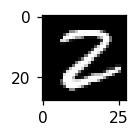

In [8]:
print_sample_digit(0)

Label: 4


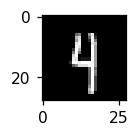

In [9]:
print_sample_digit(1)

In [0]:
# Input are images of 28 x 28 pixels each
input_size = 784 
# Hidden layers size
h1_size, h2_size, h3_size = 400,200,100 
# Output will be 10 since we will get the softmax probability for each digit (0-9)
output_size = 10 


### Define the model

In [0]:
model = nn.Sequential(
            nn.Linear(input_size, h1_size),
            nn.ReLU(),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(),
            nn.Linear(h2_size, h3_size),
            nn.ReLU(),
            nn.Linear(h3_size, output_size)
            )        

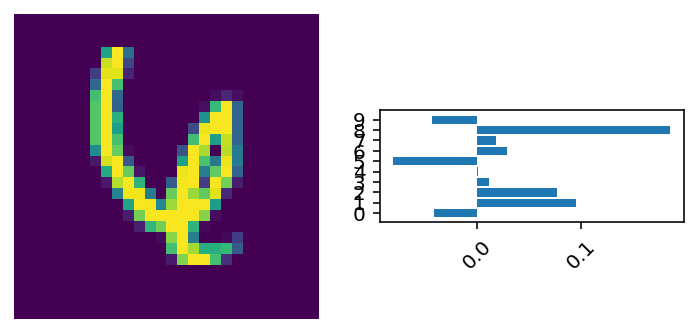

In [12]:
# Get images and labels
images, labels = next(iter(trainloader))

# Batch size
batch_size = images.shape[0]

images.resize_(batch_size, 1, 784)

# Feedforward the network
ps = model.forward(images[0,:])

# Print result for the first image
fig, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=2)
ps = ps.data.numpy().squeeze()

ax1.imshow(images[0].resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10), ps )
ax2.set_aspect(0.01)
ax2.set_yticks(np.arange(10))
plt.xticks(rotation='45')

plt.show();

# Right now since the Neural Network did not update weights yet all probabilities are roughtly the same

### Define the validation function

In [0]:
def validation(model,testloader,criterion):
    test_loss = 0
    accuracy = 0
    
    for images, labels in testloader:
        batch_size = images.shape[0]
        images.resize_(batch_size, input_size)
        
        output = model.forward(images)
        test_loss += criterion(output,labels).item()
        
        ps = torch.exp(output)
                   
        # Each probability consist in an array of 10 probabilities, the predicted class is the
        # highest probability of each one, so we need to get the max of the probabilitie for each 
        # prediction in order to find the predicted_class         
        
        predicted_classes = ps.max(dim=1)[1]
        
        # To find the correct classified items we compare labels with the predicted_classes
        # and we will get back an array of booleans with 1 if the prediction was correct or
        # 0 otherwise
        
        #correct_predictions = (labels == predicted_classes)
        correct_predictions = (labels.data == correct_predictions)

        accuracy += correct_predictions.type(torch.FloatTensor).mean()
        
        return test_loss, accuracy
        

In [0]:
# Implement a function for the validation pass
def validation2(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [0]:
# Define the Loss Function
criterion = nn.CrossEntropyLoss() 

# Define optimizer as Stochastic Gradient Descent with a learning rate of 0.01
sgd_optimizer = optim.SGD(model.parameters(), lr = 0.003)

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

### Time to train the Neural Network!

In [17]:
epochs = 5
print_every = 40
steps = 0

for epoch in range(epochs):
    running_loss = 0
    
    model.train()
    
    # Get images and labels
    for images, labels in iter(trainloader):
        steps += 1
        images.resize_(images.size()[0], input_size)
        
        # Set gradients to zero
        sgd_optimizer.zero_grad()
        
        y_hat = model.forward(images)
        loss = criterion(y_hat,labels)
        loss.backward()
        sgd_optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            with torch.no_grad():
                test_loss, accuracy = validation2(model,testloader,criterion)
            
            print("Epoch: {}/{}... ".format(epoch+1, epochs),
                  "Loss: {:.3f}".format(running_loss/print_every),
                  "Test Loss: {:.3f}".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            model.train()


Epoch: 1/5...  Loss: 2.297 Test Loss: 2.295 Test Accuracy: 0.098
Epoch: 1/5...  Loss: 2.294 Test Loss: 2.291 Test Accuracy: 0.098
Epoch: 1/5...  Loss: 2.291 Test Loss: 2.286 Test Accuracy: 0.126
Epoch: 1/5...  Loss: 2.283 Test Loss: 2.282 Test Accuracy: 0.190
Epoch: 1/5...  Loss: 2.279 Test Loss: 2.277 Test Accuracy: 0.197
Epoch: 1/5...  Loss: 2.278 Test Loss: 2.272 Test Accuracy: 0.196
Epoch: 1/5...  Loss: 2.271 Test Loss: 2.266 Test Accuracy: 0.188
Epoch: 1/5...  Loss: 2.264 Test Loss: 2.261 Test Accuracy: 0.193
Epoch: 1/5...  Loss: 2.258 Test Loss: 2.255 Test Accuracy: 0.189
Epoch: 1/5...  Loss: 2.253 Test Loss: 2.248 Test Accuracy: 0.198
Epoch: 1/5...  Loss: 2.246 Test Loss: 2.242 Test Accuracy: 0.210
Epoch: 1/5...  Loss: 2.240 Test Loss: 2.234 Test Accuracy: 0.230
Epoch: 1/5...  Loss: 2.226 Test Loss: 2.226 Test Accuracy: 0.238
Epoch: 1/5...  Loss: 2.224 Test Loss: 2.218 Test Accuracy: 0.264
Epoch: 1/5...  Loss: 2.214 Test Loss: 2.208 Test Accuracy: 0.291
Epoch: 1/5...  Loss: 2.20

### Test the Neural Network

In [25]:
images, labels = next(iter(testloader))

img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
print(ps, labels[0])


tensor([[9.9772e-01, 3.1328e-10, 9.7800e-05, 5.0191e-05, 4.4169e-08, 2.0819e-03,
         2.6801e-06, 1.8022e-06, 4.4737e-05, 1.4518e-06]]) tensor(0)


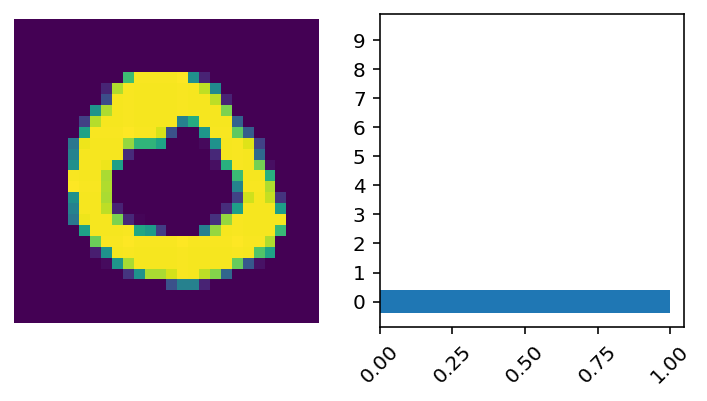

Label:  tensor(0)


In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=2)
ps = ps.data.numpy().squeeze()

ax1.imshow(images[0].resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10), ps )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
plt.xticks(rotation='45')

plt.show();
print('Label: ', labels[0])

tensor([[6.1152e-05, 1.2570e-06, 1.8525e-04, 7.1210e-05, 9.4518e-01, 4.6784e-03,
         2.6945e-03, 3.0033e-04, 1.1481e-03, 4.5684e-02]]) tensor(4)


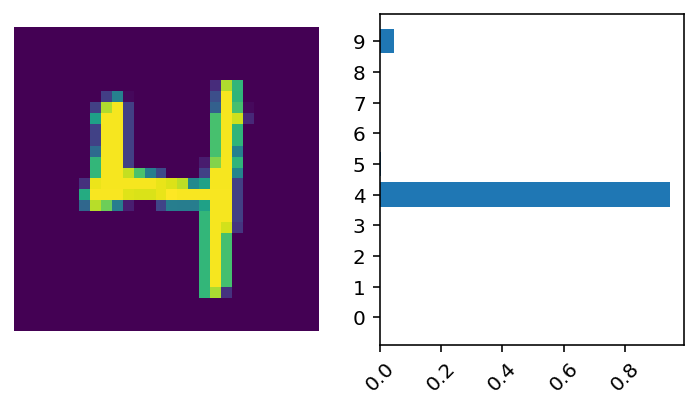

Label:  tensor(4)


In [24]:
images, labels = next(iter(testloader))

img = images[0].view(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
print(ps, labels[0])

fig, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=2)
ps = ps.data.numpy().squeeze()

ax1.imshow(images[0].resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10), ps )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
plt.xticks(rotation='45')

plt.show();
print('Label: ', labels[0])